<a href="https://colab.research.google.com/github/rtaiello/asi_2022/blob/main/Completed_Bayesian_Logistic_Regression_Laplace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import functools
import warnings

import scipy.optimize
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import scipy.stats
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tnrange


warnings.filterwarnings("ignore")

colab = "google.colab" in str(get_ipython())
preamble = r"""\renewcommand{\familydefault}{\sfdefault}\usepackage{sansmath}
\usepackage{FiraSans}\sansmath\usepackage{amsmath}"""

rc("font", **{"family": "sans-serif", "sans-serif": "DejaVu Sans"})
rc("text", **{"usetex": not colab, "latex.preamble": preamble})
rc("figure", **{"dpi": 200})
rc(
    "axes",
    **{"spines.right": False, "spines.top": False, "xmargin": 0.0, "ymargin": 0.05}
)


def plot_data(X, y, ax):
    mask = y == 1
    config = dict(edgecolor="black", linewidth=1, zorder=10)
    ax.scatter(*X[mask].T, label="Class 1", facecolor="tab:blue", **config)
    ax.scatter(*X[~mask].T, label="Class 0", facecolor="tab:orange", **config)


def get_grid(xlim=(-3, 3), ylim=None, N=100):
    if ylim is None:
        ylim = xlim
    x_grid = np.linspace(*xlim, N)
    y_grid = np.linspace(*ylim, N)
    xx, yy = np.meshgrid(x_grid, y_grid)
    X_plot = np.vstack((xx.flatten(), yy.flatten())).T
    return xx, yy, X_plot

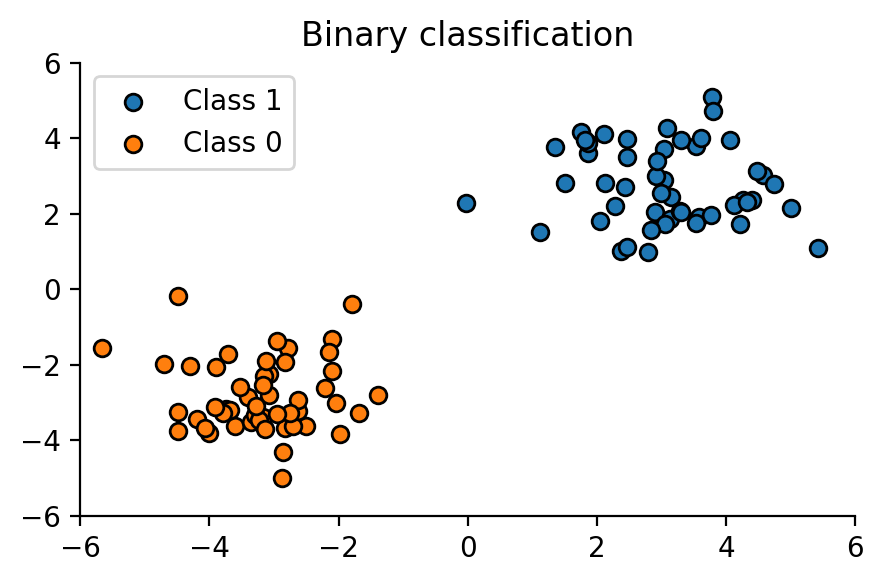

In [37]:
data = np.loadtxt("https://raw.githubusercontent.com/srossi93/asi-labs/master/lab_week3-public/binaryclass2.csv", delimiter=",")
X = data[..., :-1]
y = data[..., -1]

fig, ax = plt.subplots(figsize=[5, 3])
plot_data(X,y,ax)
ax.set_title("Binary classification")
ax.legend()
ax.set_xlim(-6, 6), ax.set_ylim(-6, 6)
plt.show()

For logistic regression (binary), we use the logistic (or sigmoid) function defined like $h(z) = (1+\exp(-z))^{-1}$.


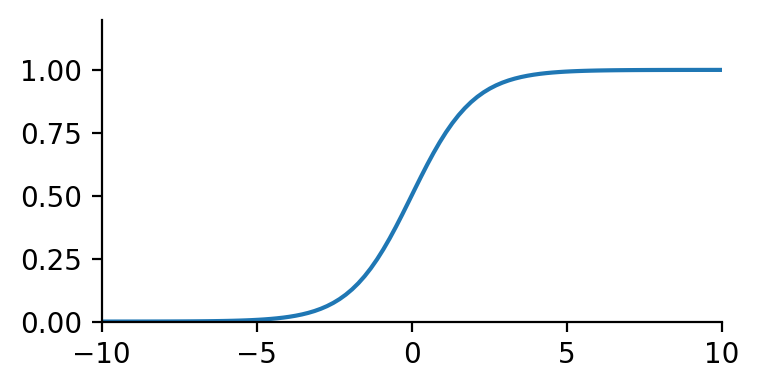

In [38]:
def logistic(z):
    return 1 / (1 + np.exp(-z))


z = np.linspace(-10, 10, 100)
fig, ax = plt.subplots(figsize=[4, 2])
ax.plot(z, logistic(z))
ax.set_ylim(0, 1.2)
plt.show()

The likelihood that we will use is the *Bernoulli likelihood*. Its (log)density is defined as follows

$$\log p({y}|{p}) = \log({p}) \quad\text{if } y = 1$$
$$\log p({y}|{p}) = \log(1 - {p}) \quad\text{if } y = 0$$

where ${y}$ is the target class [0, 1] and ${p}$ is the predictive probability (i.e. the output of the logistic regression).


In [7]:
def bernoulli_density(y, p):
    return y * np.log(p) + (1-y) * np.log(1-p)

In [8]:
def gaussian_density(x, mean=0, var=1):
    return - np.log(np.sqrt(2 * np.pi * var)) - (x-mean)  ** 2 / (2 * var)

# 2. Laplace Aproximation


The first thing that we need to compute is the un-normalized logposterior (i.e. the sum of loglikelihood and prior):

$$
\log p(\boldsymbol{w}|\boldsymbol{X},\boldsymbol{y}) \propto \log p(\boldsymbol{y}|\boldsymbol{w}, \boldsymbol{X}) + \log p(\boldsymbol{w}) := g(\boldsymbol{w}; \boldsymbol{X}, \boldsymbol{y})
$$

## MAP
We can't compute analytically $\frac{\partial g(\boldsymbol{w}; \boldsymbol{X}, \boldsymbol{y})}{\partial \boldsymbol{w}} = 0$ <br>
We go trough numerical optimization:


1.   Guess $\boldsymbol{\hat{w}}$
2.   Change it a bit in a way that increases $g(\boldsymbol{w}; \boldsymbol{X}, \boldsymbol{y})$
3. Repeat until no further increase is possible.



## Laplace aproximation
Laplace approx, involves approximating $p(\boldsymbol{w}|\boldsymbol{X},\boldsymbol{y})$ with another distribution. <br>
Find a distribution $q(\boldsymbol{w}| \boldsymbol{X}, \boldsymbol{y}) = \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{Σ})$ <br>
Where:
*  $ \boldsymbol{\mu} =  \boldsymbol{\hat{w}}$
*  $\boldsymbol{Σ}^{-1} = - \frac{∂ \log ~ g(\boldsymbol{w}; \boldsymbol{X}, \boldsymbol{y})}{∂\boldsymbol{w} ∂ \boldsymbol{w}^T} \vert \boldsymbol{\hat{w}}$ 




In [9]:
def logposterior(w, X, y):
    y_hat = logistic(X @ w)
    log_ll = bernoulli_density(y,y_hat)
    prior = gaussian_density(w)

    return (np.sum(log_ll) + np.sum(prior))

In [10]:
def neg_logposterior(w, X, y):
    # We want to minimize the negative log posterior
    y_hat = logistic(X @ w)
    log_ll = bernoulli_density(y,y_hat)
    prior = gaussian_density(w)

    return - (np.sum(log_ll) + np.sum(prior))

In [27]:
w_init = np.zeros(2)
solution = scipy.optimize.minimize(neg_logposterior, w_init, args=(X, y), method='BFGS')
solution.x
w_map = solution.x
hessian = solution.hess_inv

In [28]:
samples = scipy.stats.multivariate_normal(mean=w_map, cov=hessian).rvs(size=1000)

**Exercise:**
Plot the samples and their distribution.

In [29]:
def plot_posterior(ax):
    xx, yy, X_plot = get_grid(xlim=(-1.5, 5.5), N=250)
    vals = np.zeros(len(X_plot))
    for i, w in enumerate(X_plot):
        vals[i] = np.exp(logposterior(w, X, y))

    levels = np.linspace(1e-5, max(vals), 10)
    patch = ax.contourf(
        xx, yy, vals.reshape(*xx.shape), cmap="cividis", alpha=0.6, levels=levels
    )
    ax.contour(xx, yy, vals.reshape(*xx.shape), cmap="cividis", levels=patch.levels[0:])

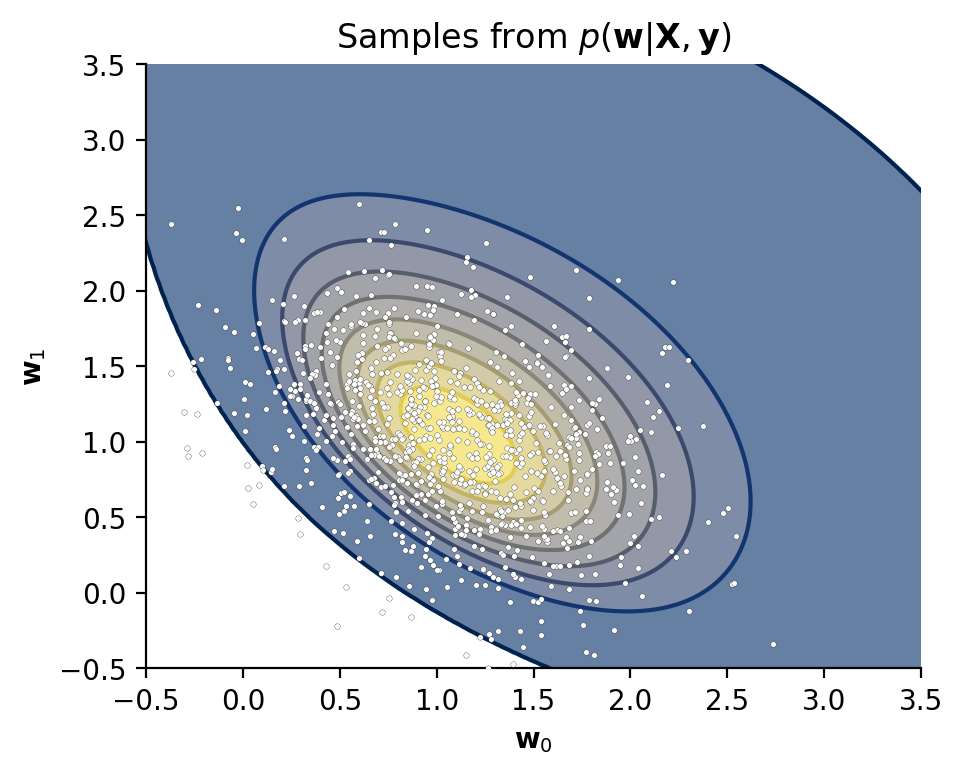

In [30]:
fig, ax = plt.subplots(figsize=[5, 4])
ax.scatter(
    *samples.T, s=4, edgecolor="black", linewidth=0.1, zorder=10, facecolor="white"
)
plot_posterior(ax)
ax.set_xlim(-0.5, 3.5), ax.set_ylim(-0.5, 3.5)
ax.set_xlabel(r"$\mathbf{w}_0$")
ax.set_ylabel(r"$\mathbf{w}_1$")
ax.set_title(r"Samples from $p(\mathbf{w}|\mathbf{X},\mathbf{y}) $")
plt.show()

Now, we can make predictions. 
Remember that our motivation for being Bayesian was to be able to average predictions at $\boldsymbol{x}_\mathrm{new}$, for all possible $\boldsymbol{w}$.
This is possible by computing the following expectation:

$$
\boldsymbol{E}_{p(\boldsymbol{w}|\boldsymbol{X}, \boldsymbol{y}, \sigma_\mathrm{n})}h(\boldsymbol{w}^\top\boldsymbol{x}_\mathrm{new}) = \int h(\boldsymbol{w}^\top\boldsymbol{x}_\mathrm{new}) p(\boldsymbol{w}|\boldsymbol{X}, \boldsymbol{y}) \mathrm{d}\boldsymbol{w}
$$


In [31]:
def predict(Xt, samples):
    Xt = np.atleast_2d(Xt)
    return 1 / samples.shape[0] * np.sum(logistic(samples @ Xt.T), axis=0)

In [32]:
predict([2, -4], samples)

array([0.27178624])

**Exercise:**
Now predict on a grid of points and plot the predictive probabilities (use the two helper function below).

In [33]:
def plot_decision_boundary(xx, yy, P, ax):
    P = P.reshape(*xx.shape)
    levels = [0, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 1]
    cs = ax.contour(xx, yy, P, levels, colors="k", linewidths=1.8, zorder=100)
    ax.clabel(cs, inline=1, fontsize=10)
    cs = ax.contourf(xx, yy, P, levels, cmap="Purples_r", alpha=0.5)

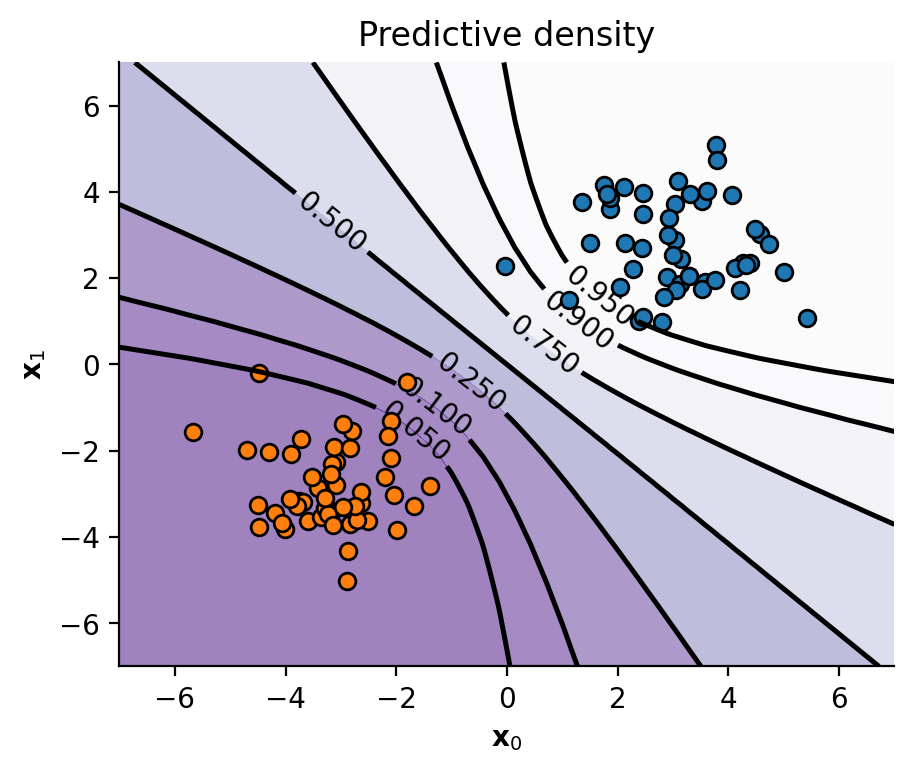

In [34]:
xx, yy, X_grid = get_grid((-7, 7), N=50)
ps = predict(X_grid, samples)

fig, ax = plt.subplots(figsize=[5, 4])
plot_decision_boundary(xx, yy, ps, ax=ax)
plot_data(X, y, ax=ax)

ax.set_xlabel(r"$\mathbf{x}_0$")
ax.set_ylabel(r"$\mathbf{x}_1$")
ax.set_title("Predictive density")
plt.show()

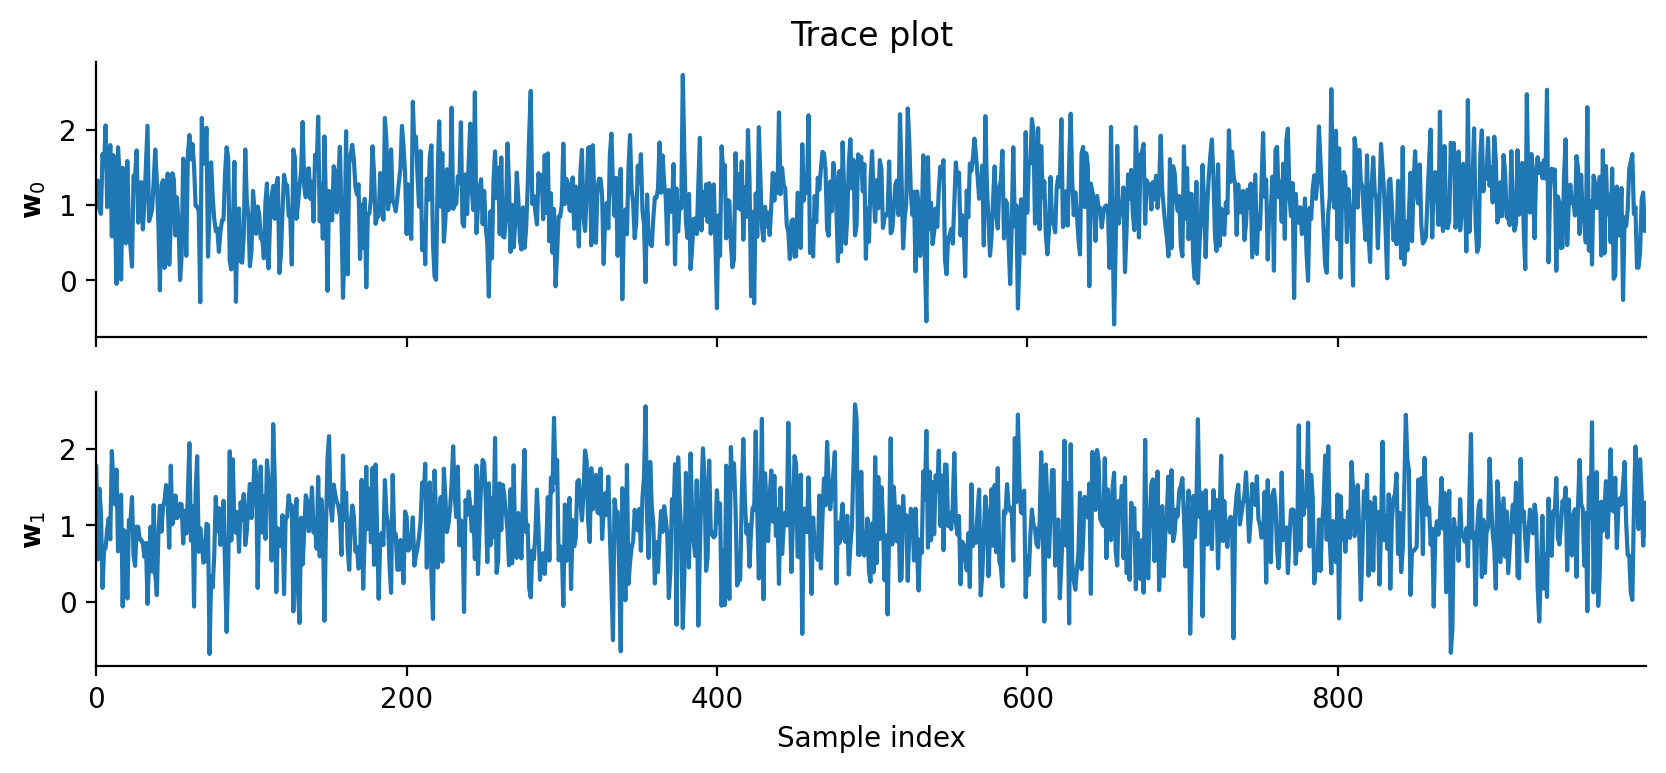

In [39]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=[10, 4], sharex=True)

ax0.plot(list(range(0, samples.shape[0])), samples[:, 0])
ax1.plot(list(range(0, samples.shape[0])), samples[:, 1])


ax0.set_ylabel(r"$\mathbf{w}_0$")
ax1.set_ylabel(r"$\mathbf{w}_1$")
ax0.set_title("Trace plot")
ax1.set_xlabel(r"Sample index")
plt.show()